In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle
import scipy.misc
import random
import os
import pandas as pd

# import parameters
#from cifar10_params import *

img_rows, img_cols, img_chns = 92, 70, 3
latent_dim = 20
intermediate_dim = 256 # 256, 512
epsilon_std = 1.0
epochs = 30
filters = 30
num_conv = 3
batch_size = 10

"""
loading vae model back is not a straight-forward task because of custom loss layer.
we have to define some architecture back again to specify custom loss layer and hence to load model back again.
"""

# tensorflow or theano
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

original_img_size = (img_rows, img_cols, img_chns)
    
# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        print(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        print(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        print(inputs)
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        loss = [1]
        self.add_loss(loss, inputs=inputs)
        return x


In [21]:
show_name = "Fall"
src_dir = "../img/%s" % show_name


In [ ]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

input_files = []
for root, dirs, files in os.walk(src_dir):
    for f in files:
        if os.path.splitext(f)[-1].lower() in [".jpg", ".JPG"]:
            os.path.join(root, f)
            input_files.append(os.path.join(root, f))
            
#input_files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if f.endswith(".jpg")]
#imgs = [Image.open(im).convert('RGB').resize((172, 260), Image.ANTIALIAS) for im in input_files]
#lwf_immatrix = np.array([np.array(im) for im in imgs])

lwf_immatrix = []
for im in input_files:
    try:
        img = Image.open(im)
    except:
        pass
    if len(np.array(img).shape) != 3:
        print(im)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.array(img))
        plt.show()
    else:
        #lwf_immatrix.append(np.array(img.resize((172, 260), Image.ANTIALIAS)))
        lwf_immatrix.append(np.array(img.resize((img_cols, img_rows), Image.ANTIALIAS))) # change in img_row! in the above cell

lwf_immatrix = np.array(lwf_immatrix)
        
    
#lwf_immatrix = np.array([np.array(Image.open(im)) for im in input_files])
print("Input size", lwf_immatrix.shape)

#plt.figure(figsize=(5, 5))
#plt.imshow(lwf_immatrix[0])
#plt.show()

x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(lwf_immatrix), test_size=0.20, random_state=42)

original_img_size = lwf_immatrix[0].shape

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
print(original_img_size)
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

In [17]:
def my_vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [18]:
# load saved models
show_name = show_name.replace("/", "_")
#vae = keras.models.load_model('../models/cifar10_%s_%d*%d_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (show_name, img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
#                                 custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})
encoder = keras.models.load_model('../models/cifar10_%s_%d*%d_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (show_name, img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
                                     custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})
generator = keras.models.load_model('../models/cifar10_%s_%d*%d_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (show_name, img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
                                       custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})

# load history if saved
fname = '../models/cifar10_ld_%s_%d*%d_%d_conv_%d_id_%d_e_%d_history.pkl' % (show_name, img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = pickle.load(fo)
    print(history)
except:
    print("training history not saved")


/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


{'val_loss': [4219.0656887755104, 3910.0038713727677, 3769.9847735969388, 3726.7843690210461, 3689.1102718431121, 3648.2433783083547, 3625.0763612085461, 3600.5335469148595, 3587.8801767777422, 3581.2158352598854, 3562.1524334343112, 3550.0244688695789, 3546.9815399792728, 3528.1786112882655, 3517.7840003188776, 3513.1157475685586, 3494.4201012436224, 3495.9284020248724, 3487.0686583227039, 3468.4245854591836, 3461.6854322783802, 3459.5285744180483, 3455.4678431919642, 3462.494873046875, 3445.8198491310586, 3441.6788006218112, 3434.0673529177297, 3432.8668287627552, 3429.3516372369259, 3424.7039221938776], 'loss': [4358.6760454021514, 4101.5658259157271, 3905.4968755336408, 3817.4743158726092, 3772.9613003756831, 3737.0156129930842, 3712.9835238430669, 3693.5613926955261, 3677.7334758154029, 3667.6171608179643, 3643.5686502091871, 3625.0921170594261, 3613.9846164724213, 3602.826856269211, 3590.8499575755636, 3572.4307467768099, 3565.6920999829235, 3553.9840388063526, 3545.0363329277666

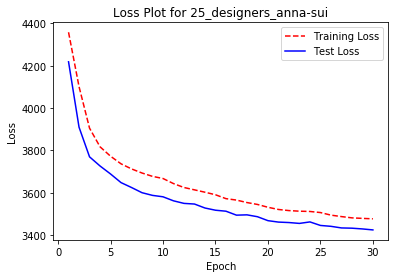

In [20]:
training_loss = history['loss']
test_loss = history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.title("Loss Plot for %s" % show_name)
#plt.title("Loss Plot for 2018 Fall Ready-To-Wear")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

[[ 0.50437961  0.21286366  0.3692283   0.50545414  0.34106115 -0.77525623
  -0.20159889 -0.43825283  0.60367277 -0.9259808  -0.45470585 -0.51634811
   0.4145466  -0.67506263 -0.94741482  0.0372933  -0.24898849 -0.62313041
  -0.98367384  0.07358358]] 1
[[ 0 -4  0  0 -4  0 -4  0  0  0 -4  0  0  0  0  0  0  0  0  0]] 1
[[-4  0 -4 -4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -4]] 1
[[ 0  0  0  0  0  0 -4  0  0  0 -4  0  0  0  0  0  0 -4 -4  0]] 1
[[-4  0  0  0 -4  0  0  0  0  0  0  0  0  0 -4 -4  0  0  0  0]] 1
[[ 0  0  0 -4  0 -4  0 -4  0  0  0  0  0  0  0 -4  0  0  0  0]] 1
[[-4  0  0  0  0  0  0  0 -4 -4  0  0  0  0  0 -4  0  0  0  0]] 1


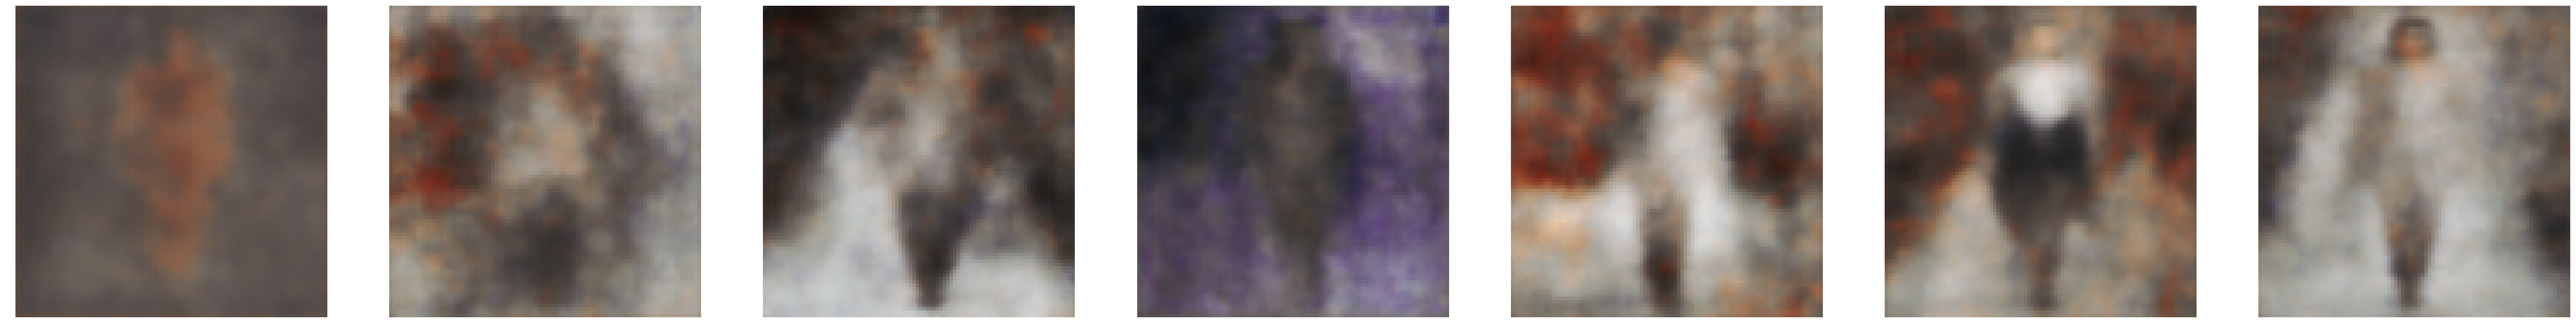

In [8]:
feature = 6
fig = plt.figure(figsize=(80, 80))
cols = feature
rows = 1

file_path = "../result_img/%s/" % show_name
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)

z_sample_avg = np.array([np.random.uniform(-1,1,size=latent_dim)])
print(z_sample_avg, len(z_sample_avg))
x_decoded = generator.predict(z_sample_avg)
img = x_decoded[0].reshape(img_rows, img_cols, img_chns)
fig.add_subplot(rows, cols+1, 1)
plt.imshow(img)
plt.axis('off')
scipy.misc.imsave(file_path+"avg.jpg", img)

z_sample_gen = [0] * latent_dim
for i in range(feature):
    z_sample = z_sample_gen.copy()
    z_pos = random.sample(range(latent_dim), 4)
    for pos in z_pos:
        z_sample[pos] = -4
    z_sample = np.array([z_sample])
    print(z_sample, len(z_sample))
    x_decoded = generator.predict(z_sample)
    img = x_decoded[0].reshape(img_rows, img_cols, img_chns)
    
    scipy.misc.imsave(file_path+"%d.jpg" % (i+1), img)
    fig.add_subplot(rows, cols+1, i+2)
    plt.imshow(img)
    plt.axis('off')
    

plt.show()
fig.savefig(file_path+"result.png", bbox_inches='tight')

[[-0.44600289  0.27551566 -0.10701517  0.217339   -0.69098196 -0.69513318
   0.81923789 -0.02438898  0.36355848  0.52584156  0.7646409   0.1775408
  -0.95473592 -0.04678391  0.43414848  0.37866799  0.6724737   0.20953302
   0.91918669  0.50112676]] 1


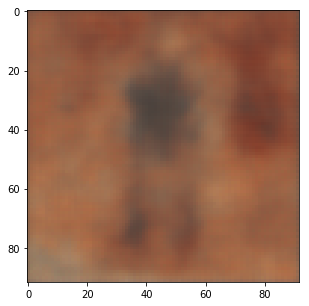

[[ 0.71160717 -0.26167647 -0.08891053  0.83455112 -0.84465174 -0.63000247
   0.19531317  0.59433125 -0.39707111  0.96576164 -0.23534075  0.83247451
  -0.06865437 -0.90825788  0.54239846  0.95464644  0.91061528 -0.59481669
  -0.27977241  0.51824682]] 1


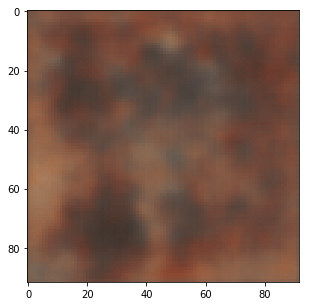

[[-0.81540258  0.8025014   0.85259759  0.96120348 -0.51349604 -0.41137931
   0.67081827  0.90503673 -0.75950194 -0.20252792  0.88127853  0.4175539
  -0.22635379 -0.902818    0.70381181 -0.32859712  0.26877599 -0.98466552
   0.02361347  0.1656151 ]] 1


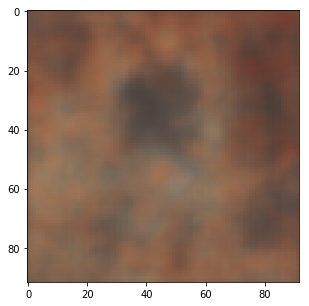

[[-0.43980993 -0.33386211 -0.61082501  0.0272737  -0.63268557  0.82438395
  -0.58932722  0.12852523  0.33811724 -0.83799378  0.98760731  0.74918173
   0.20456429  0.95402843 -0.06272411 -0.46261507 -0.4516331  -0.78819632
   0.44389026  0.88467711]] 1


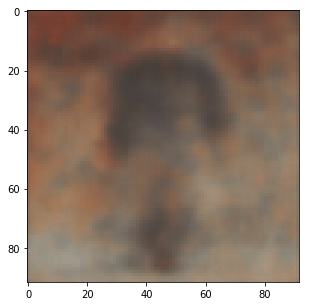

[[ 0.67409857  0.91439545  0.19646602 -0.13617782 -0.20790727 -0.23551543
   0.83828742 -0.77364913  0.23993861  0.55542106  0.20988868 -0.69689475
  -0.35436467 -0.09570619 -0.32785327 -0.81705614 -0.91813347  0.41751672
   0.2157193   0.63097651]] 1


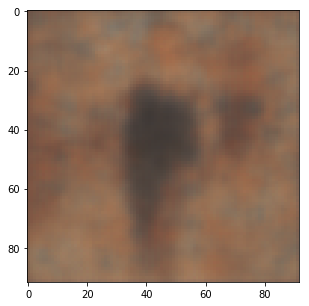

[[-0.27068839 -0.69740773  0.56943041  0.28290956 -0.58984293 -0.3640169
   0.00376747 -0.26421207  0.70106499  0.66920538 -0.27209627  0.54276217
  -0.85022588  0.58116855 -0.11900806 -0.37463071  0.18832855  0.28187658
  -0.62961162  0.51858085]] 1


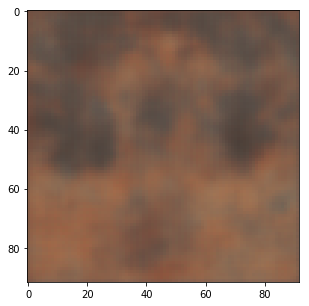

[[ -9.87261899e-01  -3.20864632e-01  -9.63057901e-01  -4.26309267e-01
    9.95894477e-02  -8.44627635e-01  -8.48792102e-01   9.05474065e-01
    5.60895550e-04   7.36164242e-01  -3.66537491e-01  -6.85871524e-01
   -6.88908733e-01  -4.75170670e-01   2.44184990e-01  -8.21588345e-01
    9.25490616e-01   2.08023912e-01  -2.93073753e-01  -2.86341438e-02]] 1


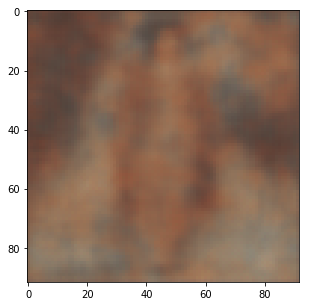

[[ 0.85420587 -0.5803477  -0.81070867  0.24068658 -0.21868715  0.37553536
   0.85447614  0.21415091  0.97953513  0.05152857  0.96683974  0.32766922
   0.52304373 -0.13786523  0.03416286  0.49579437 -0.43765172  0.40346749
  -0.34902928 -0.54923154]] 1


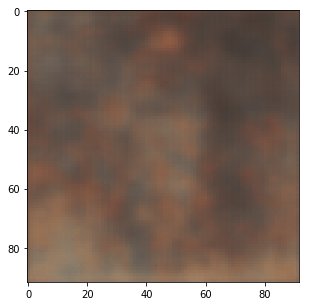

[[-0.43803527  0.57456122  0.43554906 -0.08990962  0.72001157  0.3292526
  -0.39070358  0.28966968  0.77011379  0.86007296 -0.53249832  0.72237675
   0.26211056 -0.41771467  0.97248598  0.15032997  0.86507986  0.39470757
  -0.2471567  -0.03817293]] 1


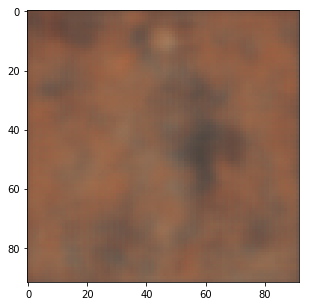

[[ 0.32870289 -0.10160736 -0.09378888 -0.88063848 -0.15575907 -0.99969148
   0.85598657 -0.55814321 -0.80705361 -0.77743438 -0.85152422  0.68451274
   0.0606809  -0.6940795   0.24320183 -0.02532944  0.57192978  0.22242461
   0.49009667  0.12245985]] 1


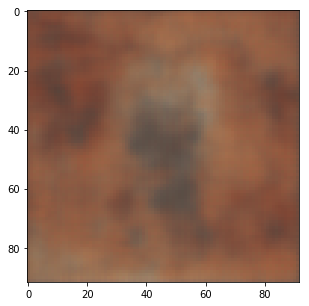

[[ 0.56107346  0.49764337  0.47241806  0.60349603 -0.81056582  0.92772668
  -0.29076741  0.45634723  0.64308283 -0.55285621  0.34900442 -0.37177823
   0.38322185  0.1040142   0.68814319  0.93204857 -0.45260641 -0.67468436
  -0.97494647  0.38113305]] 1


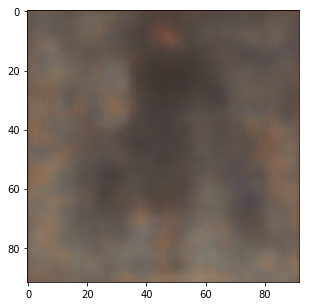

[[-0.30464512 -0.85043866 -0.7269748  -0.44744299  0.93216588  0.12222378
  -0.55934834 -0.3606782  -0.05469533  0.06513497 -0.90489224  0.38605896
   0.24302327 -0.06281407  0.31030682  0.5018976   0.75299781 -0.01618459
   0.45572555 -0.01263557]] 1


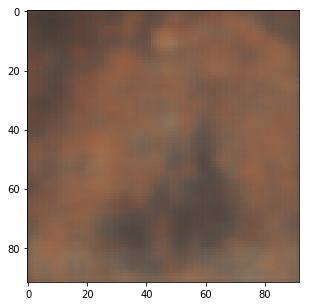

[[ 0.58083511 -0.39646015 -0.75211869 -0.73201626 -0.53587486 -0.91833059
  -0.59981875  0.19493951 -0.83834316  0.08795416  0.10854341 -0.45668171
   0.3470991  -0.66443642  0.99505053 -0.5541124   0.27510241  0.91623287
   0.00975034  0.17168462]] 1


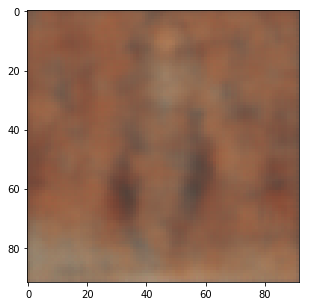

[[-0.18058254 -0.08398338 -0.02773133 -0.95521103  0.71329573  0.99824877
  -0.47074364  0.50328434  0.96218964 -0.07281712  0.89282783  0.64185542
   0.36644589 -0.31312162  0.94678871 -0.12603775  0.64906641 -0.27067039
   0.1069863   0.40137415]] 1


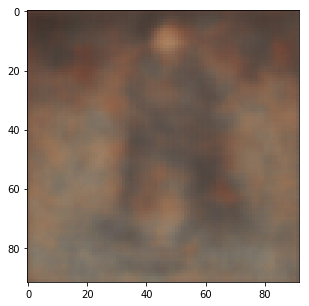

[[ 0.18457504 -0.24680285 -0.57732872 -0.7578364   0.08302456 -0.23171657
   0.8216576  -0.20929612 -0.69580806  0.58119136 -0.8865012   0.40713083
  -0.20788317 -0.30842342 -0.58512635  0.81940483  0.77608267 -0.85561242
  -0.067453   -0.93618594]] 1


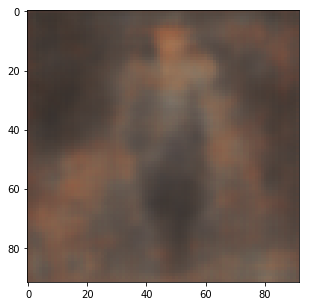

[[-0.42084349 -0.62777448 -0.63298737  0.66417512  0.31832918 -0.41174534
   0.72701898 -0.18831427 -0.54471846  0.68863549 -0.66814981 -0.50436674
  -0.20499928  0.49353174  0.26369934 -0.50778264  0.18388052 -0.76869267
  -0.83488551  0.74484953]] 1


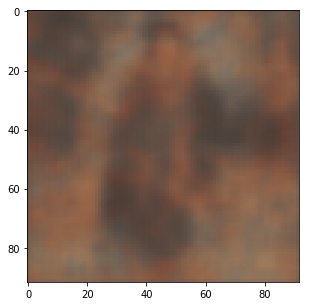

[[  5.71434966e-01   9.53897763e-01  -1.14392068e-01  -7.55380099e-04
   -3.55026884e-01   6.01897262e-01  -3.37441874e-02   3.19750086e-01
   -7.94344785e-01   9.94986514e-03  -2.40256841e-01   3.84717223e-02
    4.46797817e-02   9.63196020e-01  -8.18931444e-01   1.35217608e-01
    7.65532006e-01  -1.66939643e-01  -3.73237588e-01   7.92048966e-01]] 1


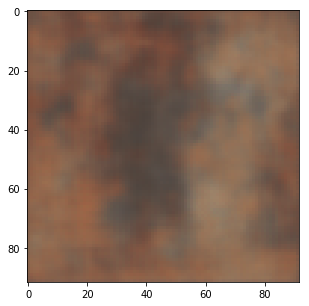

[[-0.41404342 -0.86010686  0.12560848 -0.67906063  0.6101127   0.70988886
   0.9864931   0.26815479 -0.11679881 -0.23485232  0.07141921  0.33202272
   0.25413185  0.97878423 -0.30838865 -0.17258    -0.16212269  0.42501237
   0.25405654  0.27249655]] 1


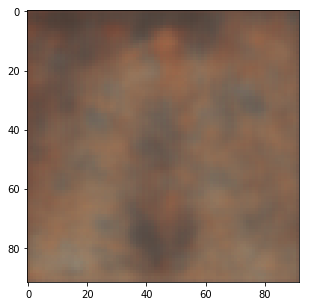

[[-0.38953072  0.58190107 -0.49148968 -0.91950004 -0.51925257  0.53435915
  -0.51294757 -0.8291513  -0.55682367  0.05735173  0.08172047 -0.13563755
   0.38718066 -0.3428167   0.76494393  0.38476737  0.6197099  -0.69001902
   0.66640071 -0.45084929]] 1


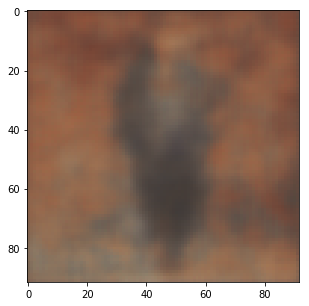

[[-0.84812845 -0.1934962  -0.89455741 -0.16214388 -0.78450682  0.58616627
   0.61203317  0.32732549  0.33294976 -0.75781403  0.75162747 -0.22392088
   0.69296641 -0.625494    0.24689113 -0.09788046 -0.79503157 -0.31622134
  -0.40484408  0.85380145]] 1


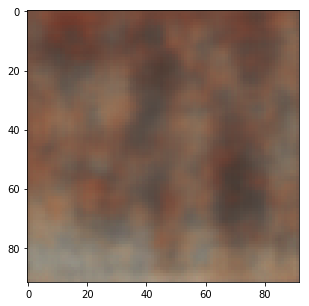

[[ 0.49807059 -0.41630755 -0.27494174  0.32496628  0.7693976  -0.92747253
   0.76110309 -0.45099421 -0.11765749  0.04225043 -0.04006549  0.12325286
   0.14338436  0.73643475  0.71324592  0.11182813  0.42097936  0.74625923
  -0.24691169  0.68127459]] 1


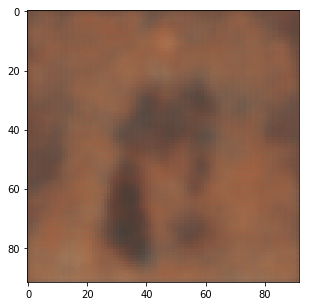

[[-0.68692185 -0.32007195 -0.61206841  0.5821607   0.05247016  0.07801287
   0.22170472  0.60272019 -0.74859597 -0.71067137  0.90913165  0.02694694
   0.79440536 -0.05805223 -0.85928324  0.27275367 -0.5658953   0.58876437
  -0.04425524 -0.12940375]] 1


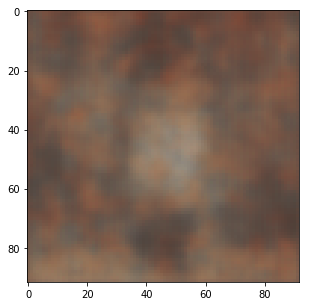

[[ 0.17935637 -0.73968364  0.34350592 -0.74205913 -0.96832144 -0.63785822
   0.65699736 -0.07281269  0.07994475  0.59085928 -0.28818627 -0.69860949
  -0.9102125  -0.55189779  0.17982443 -0.56398235 -0.87593678 -0.50626404
  -0.37815601 -0.061325  ]] 1


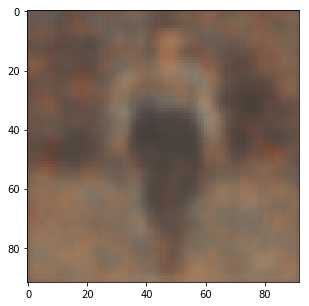

[[ 0.35517875 -0.48363447 -0.16087583  0.05301379 -0.0566932   0.22199234
   0.82045182  0.67542094 -0.88869589  0.45308556 -0.79245649  0.90887182
  -0.97494635 -0.34130022  0.05917524 -0.16358482  0.68079684  0.34120874
   0.32449848  0.07872364]] 1


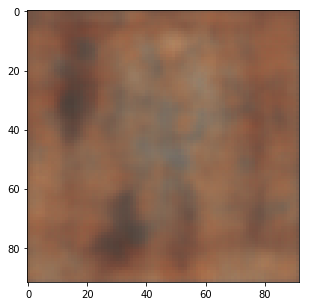

[[-0.32267959 -0.99459757 -0.24094472 -0.57720625 -0.30782395 -0.00503297
   0.70329821  0.08002954  0.50964684  0.4958048  -0.90016426 -0.19020638
   0.19557728  0.56785963 -0.59425486 -0.81399852  0.91932175  0.15194099
  -0.51922781 -0.75847065]] 1


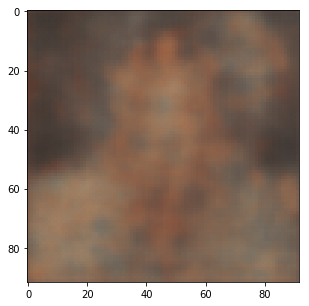

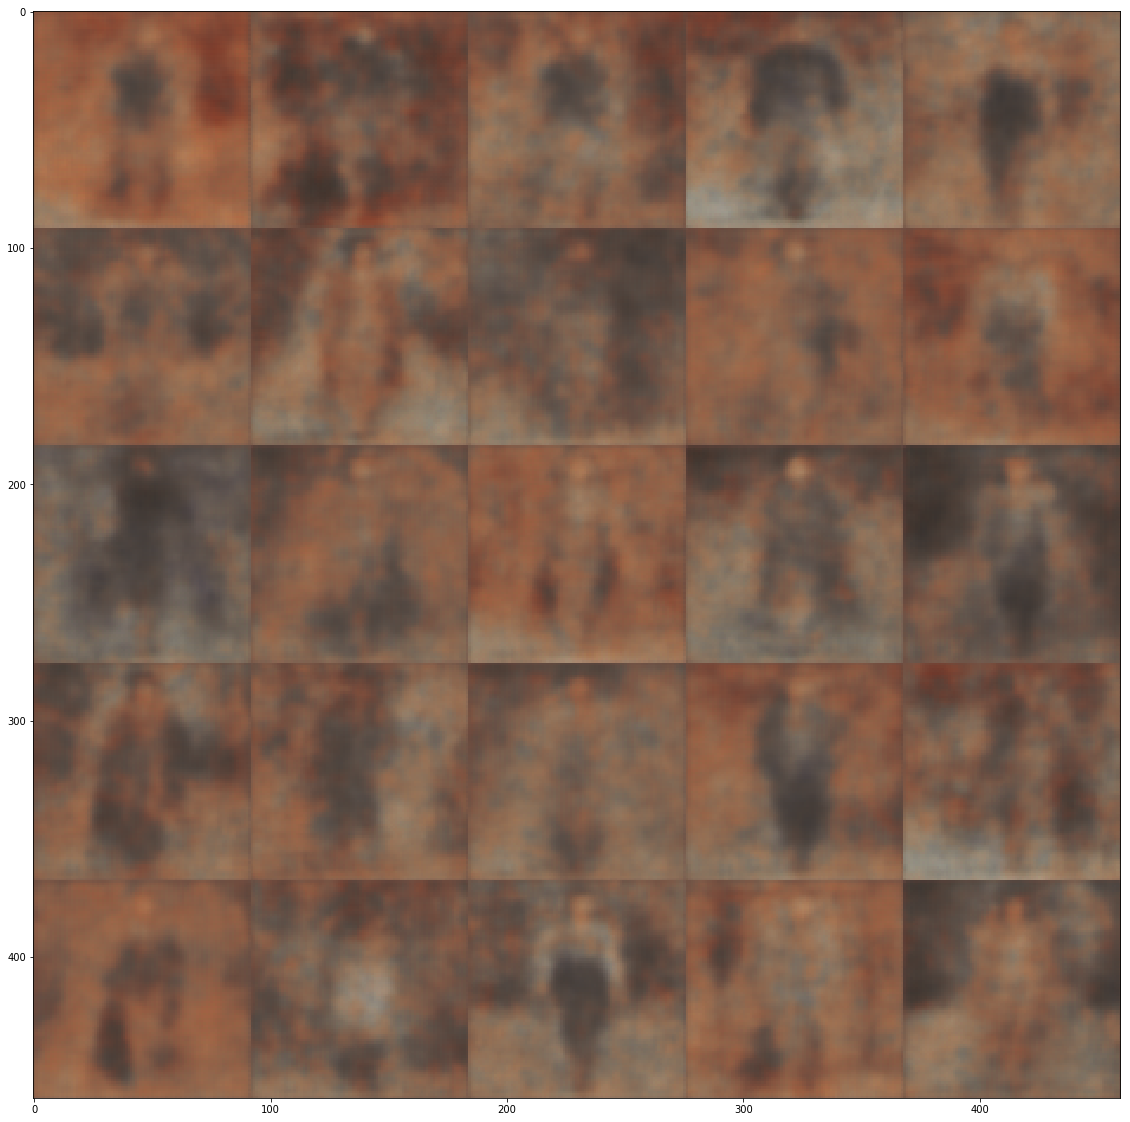

In [29]:
# display images generated from randomly sampled latent vector
n = 5
figure = np.zeros((img_cols * n, img_rows * n, img_chns))


for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1,size=latent_dim)])
        print(z_sample, len(z_sample))
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_cols, img_rows, img_chns)
        #print(img)
        figure[i * img_cols: (i + 1) * img_cols, j * img_rows: (j + 1) * img_rows] = img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
#plt.imshow(figure)
#plt.show()

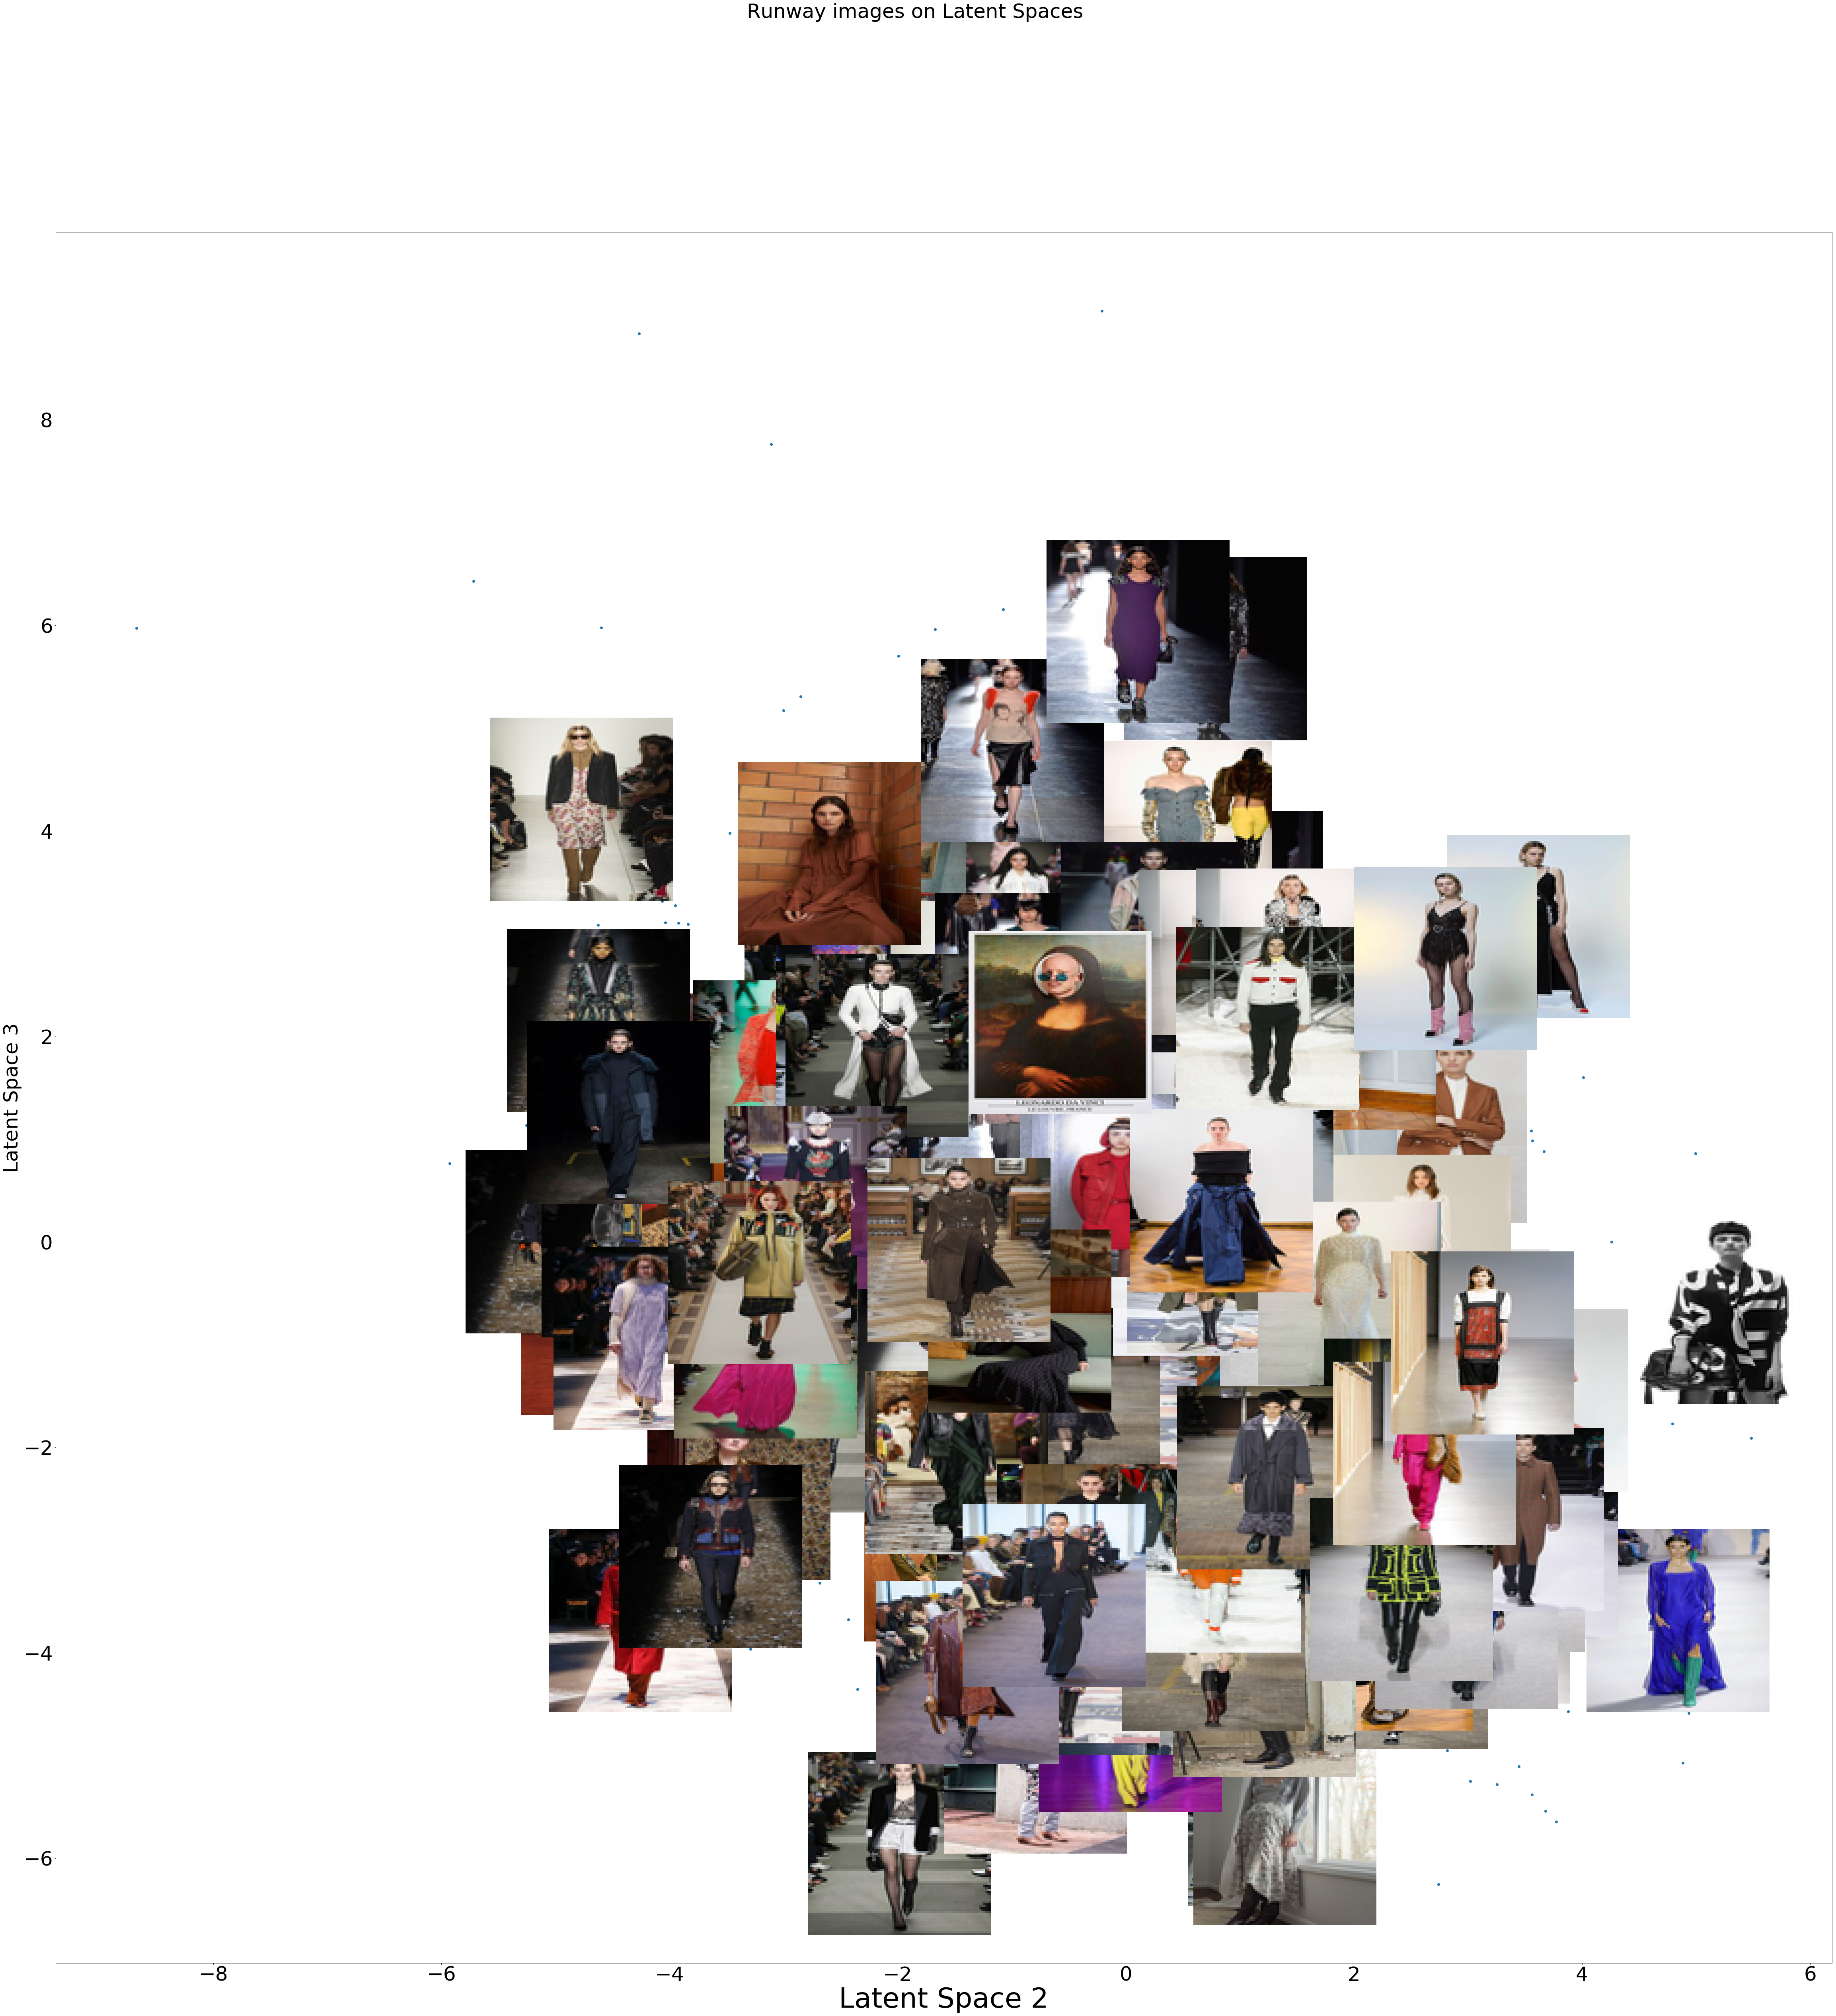

In [59]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def getImage(img,zoom=5):
    return OffsetImage(img,zoom=zoom)

imgs = x_test[:150]
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x = x_test_encoded[:, 5]
y = x_test_encoded[:, 6]


fig, ax = plt.subplots(figsize=(80, 80))
fig.suptitle("Runway images on Latent Spaces", fontsize= 50)
plt.xlabel('Latent Space 2', fontsize= 70)
plt.ylabel('Latent Space 3', fontsize= 50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
ax.scatter(x, y) 
artists = []
for x0, y0, img in zip(x, y, imgs):
    ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))
    
fig.savefig(file_path+"latent_space.png")